# Implementation of a Variational Quantum Eigensolver (VQE).

This example is based on the exampled provided by [ProjectQ](https://raw.githubusercontent.com/ProjectQ-Framework/ProjectQ/develop/examples/variational_quantum_eigensolver.ipynb), however, in this notebook the simulation of a QPU will be used instead of geting the expected value of the full Hamiltonian.

The example shown here is from the paper "Scalable Quantum Simulation of
Molecular Energies" by P.J.J. O'Malley et al. [arXiv:1512.06860v2](https://arxiv.org/abs/1512.06860v2)
(Note that only the latest arXiv version contains the correct coefficients of
 the Hamiltonian)

Eq. 2 of the paper shows the functional which one needs to minimize and Eq. 3
shows the coupled cluster ansatz for the trial wavefunction (using the unitary
coupled cluster approach). The Hamiltonian is given in Eq. 1. The coefficients
can be found in Table 1. Note that both the ansatz and the Hamiltonian can be
calculated using FermiLib which is a library for simulating quantum systems
on top of ProjectQ.

Remember that the Variational Quantum Eigensolver (VQE) is a hybrid algorithm. Part of the code is executed in the CPU (the optimisation) and part in the QPU (the calculus of the expected value of the Hamiltonian). 


In [1]:
import projectq
from projectq.ops import All, Measure, QubitOperator, TimeEvolution, X,H,S,Y,get_inverse,Rx,Ry

import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar





In [2]:
HH=QubitOperator("X1",0.2)+QubitOperator("Y1")

In [3]:
import numpy as np
HH.terms[list(HH.terms.keys())[0]]

0.2

In [4]:
ops=HH.terms
for  i in HH.terms.keys(): 
    for j in i:
        print(j[0])
        if j[1] =='X':
            print("X")
        
#    if ops[0][1] == 'Y':
#        print("Y")


1
X
1


Load the coffecientes for the Hamiltonian for each distance. This coefficientes must be calculated externally using other classical programs. 
the spin
Hamiltonian for molecular hydrogen in the minimal
(STO-6G) basis
As shown in the paper, the spin Hamiltonian for the Hydrogen Molecule in the minimal STO-6G basis, can be approximated as:

$$H=g_o I+g_1 Z_0+g_2 Z_1+g_3 Z_0 Z_1+g_4 X_0 X_1+g_5 Y_0 Y_1$$

where ${X,Y,Z}_{0,1}$ are the Pauli Matrices applied on spin 0 or 1. This table contents the calue of each $g_i$ for each bond lenght.

In [5]:
# Data from paper (arXiv:1512.06860v2) table 1: R, I, Z0, Z1, Z0Z1, X0X1, Y0Y1
raw_data_table_1 = [
    [0.20,  2.8489, 0.5678, -1.4508, 0.6799, 0.0791, 0.0791],
    [0.25,  2.1868, 0.5449, -1.2870, 0.6719, 0.0798, 0.0798],
    [0.30,  1.7252, 0.5215, -1.1458, 0.6631, 0.0806, 0.0806],
    [0.35,  1.3827, 0.4982, -1.0226, 0.6537, 0.0815, 0.0815],
    [0.40,  1.1182, 0.4754, -0.9145, 0.6438, 0.0825, 0.0825],
    [0.45,  0.9083, 0.4534, -0.8194, 0.6336, 0.0835, 0.0835],
    [0.50,  0.7381, 0.4325, -0.7355, 0.6233, 0.0846, 0.0846],
    [0.55,  0.5979, 0.4125, -0.6612, 0.6129, 0.0858, 0.0858],
    [0.60,  0.4808, 0.3937, -0.5950, 0.6025, 0.0870, 0.0870],
    [0.65,  0.3819, 0.3760, -0.5358, 0.5921, 0.0883, 0.0883],
    [0.70,  0.2976, 0.3593, -0.4826, 0.5818, 0.0896, 0.0896],
    [0.75,  0.2252, 0.3435, -0.4347, 0.5716, 0.0910, 0.0910],
    [0.80,  0.1626, 0.3288, -0.3915, 0.5616, 0.0925, 0.0925],
    [0.85,  0.1083, 0.3149, -0.3523, 0.5518, 0.0939, 0.0939],
    [0.90,  0.0609, 0.3018, -0.3168, 0.5421, 0.0954, 0.0954],
    [0.95,  0.0193, 0.2895, -0.2845, 0.5327, 0.0970, 0.0970],
    [1.00, -0.0172, 0.2779, -0.2550, 0.5235, 0.0986, 0.0986],
    [1.05, -0.0493, 0.2669, -0.2282, 0.5146, 0.1002, 0.1002],
    [1.10, -0.0778, 0.2565, -0.2036, 0.5059, 0.1018, 0.1018],
    [1.15, -0.1029, 0.2467, -0.1810, 0.4974, 0.1034, 0.1034],
    [1.20, -0.1253, 0.2374, -0.1603, 0.4892, 0.1050, 0.1050],
    [1.25, -0.1452, 0.2286, -0.1413, 0.4812, 0.1067, 0.1067],
    [1.30, -0.1629, 0.2203, -0.1238, 0.4735, 0.1083, 0.1083],
    [1.35, -0.1786, 0.2123, -0.1077, 0.4660, 0.1100, 0.1100],
    [1.40, -0.1927, 0.2048, -0.0929, 0.4588, 0.1116, 0.1116],
    [1.45, -0.2053, 0.1976, -0.0792, 0.4518, 0.1133, 0.1133],
    [1.50, -0.2165, 0.1908, -0.0666, 0.4451, 0.1149, 0.1149],
    [1.55, -0.2265, 0.1843, -0.0549, 0.4386, 0.1165, 0.1165],
    [1.60, -0.2355, 0.1782, -0.0442, 0.4323, 0.1181, 0.1181],
    [1.65, -0.2436, 0.1723, -0.0342, 0.4262, 0.1196, 0.1196],
    [1.70, -0.2508, 0.1667, -0.0251, 0.4204, 0.1211, 0.1211],
    [1.75, -0.2573, 0.1615, -0.0166, 0.4148, 0.1226, 0.1226],
    [1.80, -0.2632, 0.1565, -0.0088, 0.4094, 0.1241, 0.1241],
    [1.85, -0.2684, 0.1517, -0.0015, 0.4042, 0.1256, 0.1256],
    [1.90, -0.2731, 0.1472,  0.0052, 0.3992, 0.1270, 0.1270],
    [1.95, -0.2774, 0.1430,  0.0114, 0.3944, 0.1284, 0.1284],
    [2.00, -0.2812, 0.1390,  0.0171, 0.3898, 0.1297, 0.1297],
    [2.05, -0.2847, 0.1352,  0.0223, 0.3853, 0.1310, 0.1310],
    [2.10, -0.2879, 0.1316,  0.0272, 0.3811, 0.1323, 0.1323],
    [2.15, -0.2908, 0.1282,  0.0317, 0.3769, 0.1335, 0.1335],
    [2.20, -0.2934, 0.1251,  0.0359, 0.3730, 0.1347, 0.1347],
    [2.25, -0.2958, 0.1221,  0.0397, 0.3692, 0.1359, 0.1359],
    [2.30, -0.2980, 0.1193,  0.0432, 0.3655, 0.1370, 0.1370],
    [2.35, -0.3000, 0.1167,  0.0465, 0.3620, 0.1381, 0.1381],
    [2.40, -0.3018, 0.1142,  0.0495, 0.3586, 0.1392, 0.1392],
    [2.45, -0.3035, 0.1119,  0.0523, 0.3553, 0.1402, 0.1402],
    [2.50, -0.3051, 0.1098,  0.0549, 0.3521, 0.1412, 0.1412],
    [2.55, -0.3066, 0.1078,  0.0572, 0.3491, 0.1422, 0.1422],
    [2.60, -0.3079, 0.1059,  0.0594, 0.3461, 0.1432, 0.1432],
    [2.65, -0.3092, 0.1042,  0.0614, 0.3433, 0.1441, 0.1441],
    [2.70, -0.3104, 0.1026,  0.0632, 0.3406, 0.1450, 0.1450],
    [2.75, -0.3115, 0.1011,  0.0649, 0.3379, 0.1458, 0.1458],
    [2.80, -0.3125, 0.0997,  0.0665, 0.3354, 0.1467, 0.1467],
    [2.85, -0.3135, 0.0984,  0.0679, 0.3329, 0.1475, 0.1475]]


Funtion to calculate the expectation value of one Hamiltonian H for a state defined by $\theta$. This parameter controls the time of the evolution of the Hamiltonian $H=X_o Y_1$ applied to state $|01>$. So, the final state after this time evolution will be:

$$|\Psi\rangle = e^{-i\theta X_0 Y_1}|01\rangle$$

and the funtion will return

$$\langle H\rangle = \frac{\langle \Psi|H|\Psi\rangle}{\langle \Psi|\Psi\rangle}$$

In [6]:
def Expectation_H(theta, hamiltonian):
    """
    Args:
        theta (float): variational parameter for ansatz wavefunction
        hamiltonian (QubitOperator): Hamiltonian of the system
    Returns:
        energy of the wavefunction for parameter theta
    """
    # Create a ProjectQ compiler with a simulator as a backend
    eng = projectq.MainEngine()
    # Allocate 2 qubits in state |00>
    wavefunction = eng.allocate_qureg(2)
    # Initialize the Hartree Fock state |01>
    X | wavefunction[0]
    # build the operator for ansatz wavefunction
    ansatz_op = QubitOperator('X0 Y1')
    # Apply the unitary e^{-i * ansatz_op * t}
    TimeEvolution(theta, ansatz_op) | wavefunction
    # flush all gates
    eng.flush()
    # Calculate the energy.
    # The simulator can directly return expectation values, while on a
    # real quantum devices one would have to measure each term of the
    # Hamiltonian.
    energy = eng.backend.get_expectation_value(hamiltonian, wavefunction)
    # Measure in order to return to return to a classical state
    # (as otherwise the simulator will give an error)
    All(Measure) | wavefunction
    del eng
    return energy

To measure the results of applying Y to qubit *i*, a rotation around X by $\pi/2$ is needed. 
Similar, the result for  $X_i$ needs first a rotation around Y by $-\pi/2$.

Finally, because 

<center>$\langle 0|Z|0\rangle = +1$ and  $\langle 1|Z|1\rangle = -1$</center>

<center>$\langle 1|Z|0\rangle = 0$ and  $\langle 0|Z|1\rangle = 0$</center>

Then, for $$|\Psi>=\sum_{i=0}^{2^N-1}a_i|i\rangle $$

measureing on Z:

$$\langle\Psi|I^{\otimes m}\otimes Z^{\otimes n} |\Psi\rangle = \sum_{i=0}^{2^N-1} (-1)^{Parity\space n\space qubits\space of\space i} a_i^2$$ 

For examples, for 2 qubits:

$$\langle\Psi|Z\otimes Z |\Psi\rangle = a_0^2-a_1^2-a_2^2+a_3^2$$
$$\langle\Psi|I\otimes Z |\Psi\rangle = a_0^2-a_1^2+a_2^2-a_3^2$$
$$\langle\Psi|Z\otimes I |\Psi\rangle = a_0^2+a_1^2-a_2^2-a_3^2$$


In [7]:
def Expectation_H_shots(theta, hamiltonian,shots=1024):
    """
    Args:
        theta (float): variational parameter for ansatz wavefunction (the evolution time for the hamiltonian)
        hamiltonian (QubitOperator): Hamiltonian of the system
    Returns:
        energy of the wavefunction for parameter theta
    """
    print("Hamiltonian:",hamiltonian)
    # Create a ProjectQ compiler with a simulator as a backend
    import numpy as np
    results=np.zeros(4)
    energy1=0
    for i in range(shots):
        eng = projectq.MainEngine()
        # Allocate 2 qubits in state |00>
        wavefunction = eng.allocate_qureg(2)
        # Initialize the Hartree Fock state |01>
        X | wavefunction[0]
        # build the operator for ansatz wavefunction
        ansatz_op = QubitOperator('X0 Y1')
        # Apply the unitary e^{-i * ansatz_op * t}
        TimeEvolution(theta, ansatz_op) | wavefunction
        # flush all gates
        eng.flush()
        # Calculate the energy.
        # The simulator can directly return expectation values, while on a
        # real quantum devices one would have to measure each term of the
        # Hamiltonian.
        energy1 = eng.backend.get_expectation_value(hamiltonian, wavefunction)
        
        # However, using the results of previous cell, we can calculate using measuresements. 

        for ops in hamiltonian.terms.keys():
            for paulis in ops:
                if paulis[1] =='X':
                    #Applying Ry(-pi/2) is equivalent to apply H, but numerically introduce less error.
                    #Ry(-np.pi/2)|wavefunction[paulis[0]]
                    H | wavefunction[paulis[0]]
                if paulis[1] == 'Y':
                    #Applying Rx(pi/2) is equivalent to apply A and H (because only introduce a phace to |1>), 
                    #but numerically introduces less error
                    get_inverse(S) | wavefunction[paulis[0]]
                    H | wavefunction[paulis[0]]
                    #Rx(np.pi/2)|wavefunction[paulis[0]]

        All(Measure) | wavefunction
        eng.flush()
        results[int(wavefunction[1])*2+int(wavefunction[0])]+=1
        del eng
    print(results)
    coeff=hamiltonian.terms[list(hamiltonian.terms.keys())[0]]
    if (len(list(hamiltonian.terms.keys())[0])==0):
        print("I")
        energy=results[0]/shots+results[3]/shots+results[1]/shots+results[2]/shots 
    if (len(list(hamiltonian.terms.keys())[0])==1):
        ops=int(np.asarray(list(hamiltonian.terms.keys()))[0][0][0])
        print("Ops",ops)
        if (ops>0):
            energy=results[0]/shots+results[1]/shots-results[2]/shots-results[3]/shots
        else:
            energy=results[0]/shots-results[1]/shots+results[2]/shots-results[3]/shots            
            
    if (len(list(hamiltonian.terms.keys())[0])==2):
        energy=results[0]/shots-results[1]/shots-results[2]/shots+results[3]/shots            
    print("Coeff:",coeff, " Measured energy: ",coeff*energy," Theoretical energy:",energy1)
    return coeff*energy

Check the results when the expectation value of H is calcualted by rotations and measurements

In [8]:
expectedH=Expectation_H_shots(0.3,QubitOperator("X0 X1"),1024)

Hamiltonian: 1.0 X0 X1
[363. 117. 121. 423.]
Coeff: 1.0  Measured energy:  0.53515625  Theoretical energy: 0.5646424733950346


Funtion to calculate the expectation value of the full Hamiltonian. This function uses the property:

$$\langle \sum_{i=0}^{N}H_i\rangle = \sum_{i=0}^{N}\frac{\langle \Psi|H_i|\Psi\rangle}{\langle \Psi|\Psi\rangle}$$

Using this property, the circuit can be shallow, allowing the parallelisation of the executions in the QPU. The expectation value of each term of the Hamiltonian can be calculated in parallel because of the linearlity of the expectation value operation

In [9]:
def variational_quantum_eigensolver(theta, hamiltonian,shots=0):
    #print("Theta:",theta)
    vqe=0.
    if shots>0:
        for i in hamiltonian:
            vqe+=Expectation_H_shots(theta, i,shots)
    else:
        for i in hamiltonian:
            vqe+=Expectation_H(theta, i)
        
    return vqe

This is the main loop. For each bond length, the expectation value of the Hamiltonian is calculated, minimizing its value as function of the parameter $\theta$

In [10]:
lowest_energies = []
lowest_energies_shots = []
bond_distances = []
for i in range(len(raw_data_table_1)):
    # Use data of paper to construct the Hamiltonian
    print("Calculating for Bond distance:",i)
    bond_distances.append(raw_data_table_1[i][0])
    hamiltonian=[]
    hamiltonian.append(raw_data_table_1[i][1] * QubitOperator(()))  # == identity
    hamiltonian.append(raw_data_table_1[i][2] * QubitOperator("Z0"))
    hamiltonian.append(raw_data_table_1[i][3] * QubitOperator("Z1"))
    hamiltonian.append(raw_data_table_1[i][4] * QubitOperator("Z0 Z1"))
    hamiltonian.append(raw_data_table_1[i][5] * QubitOperator("X0 X1"))
    hamiltonian.append(raw_data_table_1[i][6] * QubitOperator("Y0 Y1"))

    # Use Scipy to perform the classical outerloop of the variational
    # eigensolver, i.e., the minimization of the parameter theta.
    # See documentation of Scipy for different optimizers.
    minimum = minimize_scalar(lambda theta: variational_quantum_eigensolver(theta, hamiltonian,shots=0))
    #minimumShots = minimize_scalar(lambda theta: variational_quantum_eigensolver(theta, hamiltonian,shots=1024))
    lowest_energies.append(minimum.fun)
    #lowest_energies_shots.append(minimumShots.fun)



Calculating for Bond distance: 0
Calculating for Bond distance: 1
Calculating for Bond distance: 2
Calculating for Bond distance: 3
Calculating for Bond distance: 4
Calculating for Bond distance: 5
Calculating for Bond distance: 6
Calculating for Bond distance: 7
Calculating for Bond distance: 8
Calculating for Bond distance: 9
Calculating for Bond distance: 10
Calculating for Bond distance: 11
Calculating for Bond distance: 12
Calculating for Bond distance: 13
Calculating for Bond distance: 14
Calculating for Bond distance: 15
Calculating for Bond distance: 16
Calculating for Bond distance: 17
Calculating for Bond distance: 18
Calculating for Bond distance: 19
Calculating for Bond distance: 20
Calculating for Bond distance: 21
Calculating for Bond distance: 22
Calculating for Bond distance: 23
Calculating for Bond distance: 24
Calculating for Bond distance: 25
Calculating for Bond distance: 26
Calculating for Bond distance: 27
Calculating for Bond distance: 28
Calculating for Bond dis

Ok. This is the end. Show the results

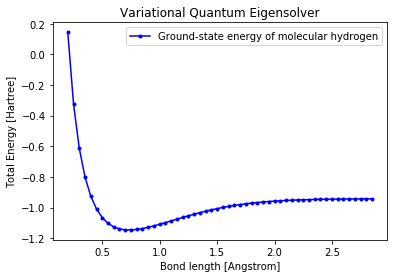

In [11]:
# print result
plt.xlabel("Bond length [Angstrom]")
plt.ylabel("Total Energy [Hartree]")
plt.title("Variational Quantum Eigensolver")
plt.plot(bond_distances, lowest_energies, "b.-",
         label="Ground-state energy of molecular hydrogen")
plt.legend()
plt.show()